In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def read_disk(disk_num):
    disk=str(disk_num)
    hcp_dir_disk='/home/hcp_data_unzipped/disk'+str(disk_num)
    hcp_dir_disk_folders=os.listdir(hcp_dir_disk)
    hcp_dir_disk_list=[]
    for folder in hcp_dir_disk_folders:
        temp=os.path.join(hcp_dir_disk,folder)
        if os.path.isdir(temp):
            hcp_dir_disk_list.append(temp)
    hcp_dir_disk_list=[x for x in hcp_dir_disk_list if '3T' not in x]
    hcp_dir_disk_list=[x for x in hcp_dir_disk_list if 'all' not in x]
    s='/MNINonLinear/Results'
    sub_folders=[fol + s for fol in hcp_dir_disk_list if os.path.isdir(fol+s)]
    start_string="disk"+str(disk_num)+"/"
    end_string="/MNI"
    expected_folders = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR','rfMRI_REST2_RL']  # Replace with your list of main directories
    defective_subs = []
    for main_dir in sub_folders:
        subdirs = os.listdir(main_dir)
        if all(subdir in subdirs for subdir in expected_folders):
        #print(f"All subdirectories present in {main_dir}")
            pass
        else:
            missing_subdirs = [subdir for subdir in expected_folders if subdir not in subdirs]
            print(f"Missing subdirectories in {main_dir}: {missing_subdirs}")
            defective_subs.append(sub_index_extractor(start_string,end_string,main_dir))
    for main_dir in sub_folders:
        subdirs = os.listdir(main_dir)
    if all(subdir in subdirs for subdir in expected_folders):
        #print(f"All subdirectories present in {main_dir}")
        pass
    else:
        missing_subdirs = [subdir for subdir in expected_folders if subdir not in subdirs]
        print(f"Missing subdirectories in {main_dir}: {missing_subdirs}")
        defective_subs.append(sub_index_extractor(start_string,end_string,main_dir))

    subs1=[sub_index_extractor(start_string,end_string,x) for x in sub_folders]

    ## eliminate the ones in defective_subs from subs
    subs1=[x for x in subs1 if x not in defective_subs]     
    print("Reading the two pickle files for disk "+disk)
    day1_filename='day_1_disk'+disk+'_concat.pickle'
    day2_filename='day_2_disk'+disk+'_concat.pickle'
    current_directory=os.getcwd()
    print(current_directory)
    pickle_file_day1=os.path.join(current_directory, day1_filename)
    pickle_file_day2=os.path.join(current_directory, day2_filename)
    with open(pickle_file_day1, 'rb') as file:
        loaded_data = pickle.load(file)
    loaded_data_day1_initial=np.array(loaded_data)

    with open(pickle_file_day2, 'rb') as file:
        loaded_data = pickle.load(file)
    loaded_data_day2_initial=np.array(loaded_data)

    defective=[]
    for i in range(len(loaded_data_day1_initial)):
        if np.all(loaded_data_day1_initial[i]==0) or np.all(loaded_data_day2_initial[i]==0):
            print("all zero at index:  " +str(i))
            defective.append(i)
    defective=np.unique(defective)
## eliminate the defective subjects from loaded_data_day1_initial and loaded_data_day2_initial
    if len(defective)>0:
        loaded_data_day1=np.delete(loaded_data_day1_initial,defective,axis=0)
        loaded_data_day2=np.delete(loaded_data_day2_initial,defective,axis=0)
        subs1_start=np.delete(subs1,defective,axis=0)
    ## eliminate the defective subjects from subs
    else:
        subs1_start=subs1
        loaded_data_day1=loaded_data_day1_initial
        loaded_data_day2=loaded_data_day2_initial
    loaded_data1=loaded_data_day1
    loaded_data2=loaded_data_day2
    return loaded_data1,loaded_data2,subs1_start


def sub_index_extractor(start_string,end_string,address):

   
    start_index = address.find(start_string)
    end_index = address.find(end_string, start_index + len(start_string))
    
    if start_index != -1 and end_index != -1:
        extracted_text = address[start_index + len(start_string):end_index].strip()
        return extracted_text
    else:
        return None
def get_dynamic_time_series(matrix, window_size,window_step,num_regs):
    print("The shape of the matrix is: "+str(matrix.shape))
    num_time_points=len(matrix[0][0])
    print("The number of time points is: "+str(num_time_points))
    num_windows=(num_time_points-window_size)//window_step+1
    print("The number of windows is: "+str(num_windows))    
    dyn_mat=np.zeros((len(matrix),num_windows,num_regs,window_size))
    for i in range(len(matrix)):
        for j in range(num_windows):
            dyn_mat[i,j,:,:]=matrix[i][:,j*window_step:j*window_step+window_size]
    return dyn_mat

def corr_mat_calculator(Three_d_matrix):
    corr_mat=np.zeros((len(Three_d_matrix),len(Three_d_matrix[1]),len(Three_d_matrix[1]))) 
    for i in range(len(Three_d_matrix)):
        temp_correlation=np.corrcoef(Three_d_matrix[i])
        corr_mat[i,:,:]=temp_correlation
    return corr_mat
def get_corr_strength(matrix_3d):
    num_subs=len(matrix_3d)
    num_windows=len(matrix_3d[0])
    num_regions=len(matrix_3d[0][0])
    conn_strength=np.zeros((num_subs,num_regions,num_windows))
    for i in range(num_subs):
        for j in range(num_windows):
            conn_strength[i,:,j]=np.sum(matrix_3d[i,j,:,:],axis=1)   
    return conn_strength 

def upper_triangular_vector(matrix):
    vecs=np.zeros((len(matrix),len(matrix[1])*(len(matrix[1])-1)//2))
    for i in range(len(matrix)):
        vecs[i]=matrix[i][np.triu_indices(len(matrix[1]),k=1)]
    return vecs

def plot_identification_mat(mat1,mat2):
    identification_mat=np.zeros((mat1.shape[0],mat2.shape[0]))
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[0]):
            identification_mat[i,j]=np.corrcoef(mat1[i],mat2[j])[0,1]
    ## plot the identification matrix
    plt.figure(figsize=(10,10))
    plt.imshow(identification_mat,aspect='auto',cmap='jet')
    plt.colorbar()
    plt.xlabel('day 2')
    plt.ylabel('day 1')
    plt.title('Identification matrix')
    plt.show()
    return identification_mat

def standardization(three_d_matrix):
    three_d_matrix_std=np.zeros_like(three_d_matrix)
    for i in range(len(three_d_matrix)):
        for j in range(len(three_d_matrix[0])):
            current_mean=np.mean(three_d_matrix[i][j])
            current_std=np.std(three_d_matrix[i][j])
            three_d_matrix_std[i][j]=(three_d_matrix[i][j]-current_mean)/current_std
    return three_d_matrix_std


def make_corr_vec(mat):
    curr=corr_mat_calculator(mat)
    vecs=upper_triangular_vector(curr)
    return vecs

def get_back_to_mat(vec,sym_mat_size):
    sym_mat=np.zeros((sym_mat_size,sym_mat_size))
    k=0
    for i in range(sym_mat_size):
        for j in range(sym_mat_size):
            if i==j:
                sym_mat[i,j]=1
            if i<j:
                sym_mat[i,j]=vec[k]
                k+=1
    for i in range(sym_mat_size):
        for j in range(sym_mat_size):
            if i>j:
                sym_mat[i,j]=sym_mat[j,i]
    return sym_mat

def give_double_index_to_vec(vec,num_regs):
    double_index_vec=np.zeros((len(vec),2))
    print(np.shape(double_index_vec))
    k=0
    for i in range(num_regs):
        for j in range(i+1,num_regs):
            double_index_vec[k]=(i,j)
            #print("Indices given to the vector: "+str(i)+","+str(j))
            k+=1
    return double_index_vec


def strength_based_analysis(day1_strength,day2_strength,day1_sub_clusters,day2_sub_clusters,n_sub_clusters):
    day1_sub_clusters_averages=np.zeros((len(day1_strength),n_sub_clusters,len(day1_strength[0][0])))
    day2_sub_clusters_averages=np.zeros((len(day2_strength),n_sub_clusters,len(day2_strength[0][0])))
    for i in range(len(day1_strength)):
        for j in range(n_sub_clusters):
            day1_sub_clusters_averages[i,j]=np.mean(day1_strength[i][day1_sub_clusters[i]==j],axis=0)
    for i in range(len(day2_strength)):
        for j in range(n_sub_clusters):
            day2_sub_clusters_averages[i,j]=np.mean(day2_strength[i][day2_sub_clusters[i]==j],axis=0)
    sub_clusters_day1_concat=np.concatenate((day1_sub_clusters_averages),axis=0)
    sub_clusters_day2_concat=np.concatenate((day2_sub_clusters_averages),axis=0)
    clusters_pool=np.concatenate((sub_clusters_day1_concat,sub_clusters_day2_concat),axis=0)
    return clusters_pool


def corr_vec_based_analysis(day1_corr_mat,day2_corr_mat,day1_sub_clusters,day2_sub_clusters,n_sub_clusters):
    day1_sub_clusters_averages=np.zeros((len(day1_corr_mat),n_sub_clusters,len(day1_corr_mat[0][0])))
    day2_sub_clusters_averages=np.zeros((len(day2_corr_mat),n_sub_clusters,len(day2_corr_mat[0][0])))
    for i in range(len(day1_corr_mat)):
        for j in range(n_sub_clusters):
            day1_sub_clusters_averages[i,j]=np.mean(day1_corr_mat[i][day1_sub_clusters[i]==j],axis=0)
    for i in range(len(day2_corr_mat)):
        for j in range(n_sub_clusters):
            day2_sub_clusters_averages[i,j]=np.mean(day2_corr_mat[i][day2_sub_clusters[i]==j],axis=0)
    print(np.shape(day1_sub_clusters_averages))
    sub_clusters_day1_concat=np.concatenate((day1_sub_clusters_averages),axis=0)
    sub_clusters_day2_concat=np.concatenate((day2_sub_clusters_averages),axis=0)
    print(np.shape(sub_clusters_day1_concat))
    clusters_pool=np.concatenate((sub_clusters_day1_concat,sub_clusters_day2_concat),axis=0)
    return clusters_pool


## You might need to define a minimum threshold for inclusion as a cluster in later analysis

import numpy as np
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
def correlation_based_hierarchical_clustering(mat,num_clusters):
    correlation_matrix = np.corrcoef(mat, rowvar=True)
    distance_matrix = 1 - np.abs(correlation_matrix)
## make distance_matrix 3 digits precision
    distance_matrix=np.round(distance_matrix,3)
    condensed_distance_matrix = ssd.squareform(distance_matrix)
    Z = linkage(condensed_distance_matrix, method='average')
    ## GET LABELS OF THE LEAVES AND NAME THEM out
    clusters=fcluster(Z, num_clusters, criterion='maxclust')
    return clusters



In [3]:
loaded_data_day1_disk1,loaded_data_day2_disk1,subs1_start=read_disk(1)

day1_LR=loaded_data_day1_disk1[:,:,:int(np.shape(loaded_data_day1_disk1)[2]/2)]
day1_RL=loaded_data_day1_disk1[:,:,int(np.shape(loaded_data_day1_disk1)[2]/2):]
day2_LR=loaded_data_day2_disk1[:,:,:int(np.shape(loaded_data_day2_disk1)[2]/2)]
day2_RL=loaded_data_day2_disk1[:,:,int(np.shape(loaded_data_day2_disk1)[2]/2):]

Reading the two pickle files for disk 1
/home/aghaffari/lcaging_fmri/parcellation_tut


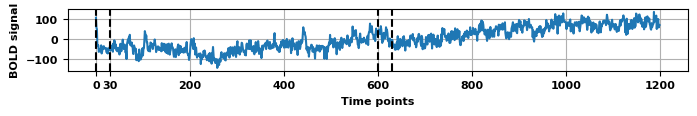

In [4]:
z=day1_LR[0][28]
## make the mean of zzero
z=z-np.mean(z)
## PLOT day1_LR for sub 0 region 0
plt.figure(figsize=(8,0.8))
plt.plot(z)
## make the figure size
## make x label and ylable numbers bigger and thicker
plt.xlabel('Time points',fontsize=8,fontweight='bold')
plt.ylabel('BOLD signal',fontsize=8,fontweight='bold')
## make x ticks bigger and thicker
special_x = 30

plt.xticks([0, 200, 400, special_x, 600, 800,1000,1200], ['0', '200', '400', str(special_x), '600', '800','1000','1200'])
plt.xticks(fontsize=8,fontweight='bold')
## make y ticks bigger and thicker
plt.yticks(fontsize=8,fontweight='bold')
## make the title bigger and thicker
## add two vertical dashed lines at x=0 and x=30
plt.axvline(x=0,color='black',linestyle='--')
plt.axvline(x=30,color='black',linestyle='--')
## shot x=30 on the x axis at the bottom

plt.axvline(x=600,color='black',linestyle='--')
plt.axvline(x=630,color='black',linestyle='--')

plt.grid()
plt.show()

In [130]:
num_regs=268
window_size=40
window_step=2
num_time_points=len(day1_LR[0][0])
num_windows=(num_time_points-window_size)//window_step+1
LR1_timeseries=get_dynamic_time_series(day1_LR,window_size,window_step,num_regs)
RL1_timeseries=get_dynamic_time_series(day1_RL,window_size,window_step,num_regs)
LR2_timeseries=get_dynamic_time_series(day2_LR,window_size,window_step,num_regs)
RL2_timeseries=get_dynamic_time_series(day2_RL,window_size,window_step,num_regs)

The shape of the matrix is: (100, 268, 1200)
The number of time points is: 1200
The number of windows is: 581


The shape of the matrix is: (100, 268, 1200)
The number of time points is: 1200
The number of windows is: 581
The shape of the matrix is: (100, 268, 1200)
The number of time points is: 1200
The number of windows is: 581
The shape of the matrix is: (100, 268, 1200)
The number of time points is: 1200
The number of windows is: 581


In [131]:
day1_LR_corr_mat=np.zeros((len(LR1_timeseries),num_windows,num_regs*(num_regs-1)//2),dtype=np.float32)
day1_RL_corr_mat=np.zeros((len(RL1_timeseries),num_windows,num_regs*(num_regs-1)//2),dtype=np.float32)
day2_LR_corr_mat=np.zeros((len(LR2_timeseries),num_windows,num_regs*(num_regs-1)//2),dtype=np.float32)  
day2_RL_corr_mat=np.zeros((len(RL2_timeseries),num_windows,num_regs*(num_regs-1)//2),dtype=np.float32)
for i in range(num_windows):
    if i%50==0:
        print("window number: "+str(i))
    day1_LR_corr_mat[:,i,:]=make_corr_vec(LR1_timeseries[:,i,:,:])
    day1_RL_corr_mat[:,i,:]=make_corr_vec(RL1_timeseries[:,i,:,:])
    day2_LR_corr_mat[:,i,:]=make_corr_vec(LR2_timeseries[:,i,:,:])
    day2_RL_corr_mat[:,i,:]=make_corr_vec(RL2_timeseries[:,i,:,:])

window number: 0


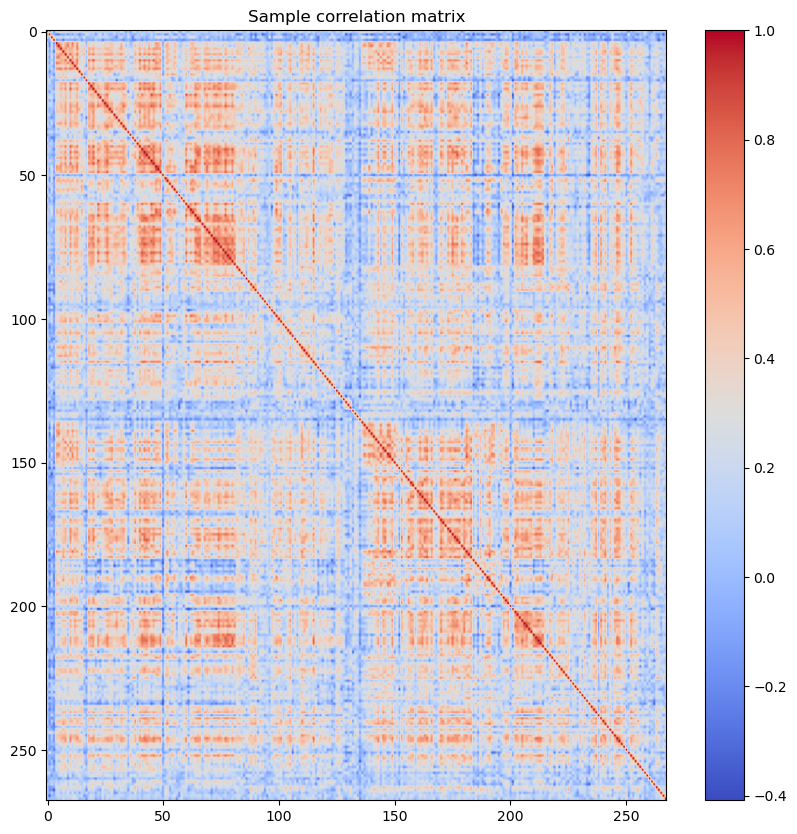

In [ ]:
## plot the sample correlation matrix
sample_corr_mat=get_back_to_mat(day1_LR_corr_mat[0,0,:],num_regs)
plt.figure(figsize=(10,10))
plt.imshow(sample_corr_mat,aspect='auto',cmap='coolwarm')
plt.colorbar()
plt.title('Sample correlation matrix')
plt.show()


In [ ]:
## So each region should take these indices from the corr vec in order to calculate their correlation strength
indices=np.zeros((num_regs,num_regs-1))
favs=give_double_index_to_vec(day1_LR_corr_mat[0,0,:],num_regs)
np.shape(favs)
for i in range(len(indices)):
    k=0
    for j in range(len(favs)):
        if favs[j][0]==i:
            indices[i][k]=j
            k+=1
        if favs[j][1]==i:
            indices[i][k]=j
            k+=1
indices=indices.astype(int)

(35778, 2)


In [ ]:
day1_corr_mat=np.concatenate((day1_LR_corr_mat,day1_RL_corr_mat),axis=1,dtype=np.float16)
day2_corr_mat=np.concatenate((day2_LR_corr_mat,day2_RL_corr_mat),axis=1,dtype=np.float16)
#del day1_LR_corr_mat,day1_RL_corr_mat,day2_LR_corr_mat,day2_RL_corr_mat ## svae us some memory
day1_corr_mat_mean=np.mean(day1_corr_mat,axis=(0,1))
day2_corr_mat_mean=np.mean(day2_corr_mat,axis=(0,1))
mean_corr_mat_mean=(day1_corr_mat_mean+day2_corr_mat_mean)/2

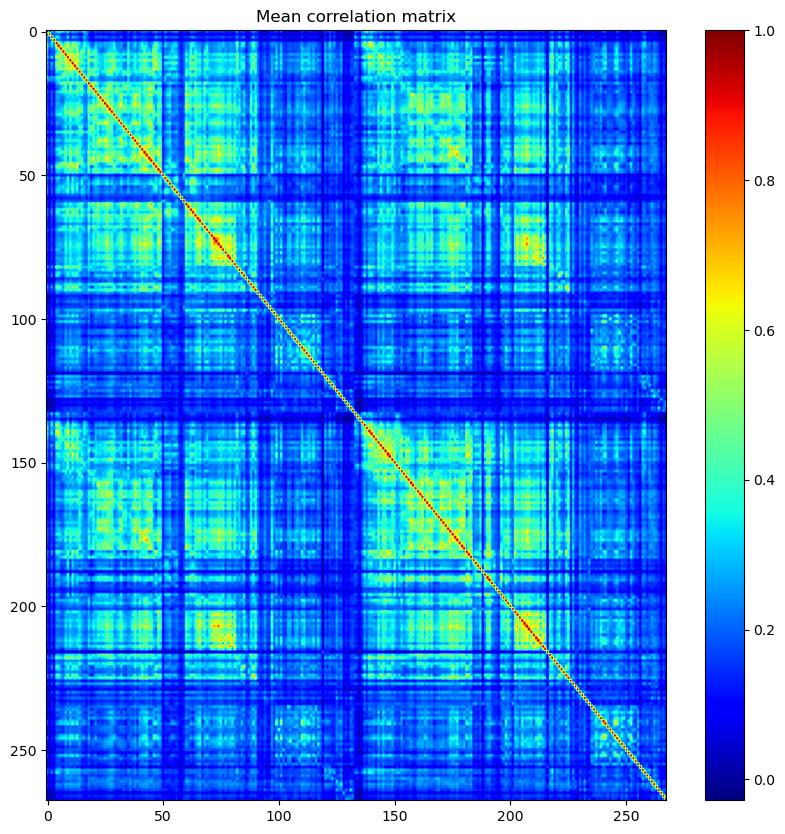

In [ ]:
mean=get_back_to_mat(mean_corr_mat_mean,num_regs)
plt.figure(figsize=(10,10))
plt.imshow(mean,aspect='auto',cmap='jet')
plt.colorbar()
plt.title('Mean correlation matrix')
plt.show()


In [36]:
day1_corr_mat_demeaned=np.zeros_like(day1_corr_mat,dtype=np.float32)
day2_corr_mat_demeaned=np.zeros_like(day2_corr_mat,dtype=np.float32)
for i in range(len(day1_corr_mat)):
    if i%5==0:
        print("subject number: "+str(i))
    for j in range(len(day1_corr_mat[0])):
        day1_corr_mat_demeaned[i,j,:]=day1_corr_mat[i,j,:]-mean_corr_mat_mean
        day2_corr_mat_demeaned[i,j,:]=day2_corr_mat[i,j,:]-mean_corr_mat_mean

subject number: 0
subject number: 5
subject number: 10
subject number: 15
subject number: 20
subject number: 25
subject number: 30
subject number: 35
subject number: 40
subject number: 45
subject number: 50
subject number: 55
subject number: 60
subject number: 65
subject number: 70
subject number: 75
subject number: 80
subject number: 85
subject number: 90
subject number: 95


In [ ]:
day1_strength_demeaned=np.zeros((len(day1_corr_mat_demeaned),num_windows*2,num_regs))
day2_strength_demeaned=np.zeros((len(day1_corr_mat_demeaned),num_windows*2,num_regs))


for i in range(len(LR1_timeseries)):
    print("Subject number: "+str(i))
    for j in range(num_windows*2):
        #print("Window number: "+str(j))
        for k in range(num_regs):
            day1_strength_demeaned[i,j,k]=np.sum(day1_corr_mat_demeaned[i,j,indices[k]])
            day2_strength_demeaned[i,j,k]=np.sum(day2_corr_mat_demeaned[i,j,indices[k]])

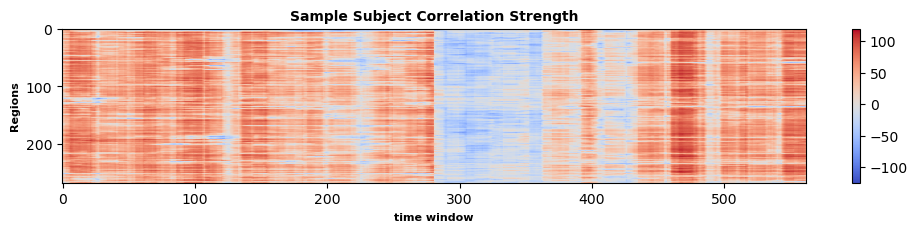

In [40]:
## sample plot of one of the clusters
sample_strength=np.transpose(day1_strength_demeaned[70])
## plot the sample strength like a heatmap
plt.figure(figsize=(12,2))
plt.imshow(sample_strength,aspect='auto',cmap='coolwarm')
plt.colorbar()
plt.xlabel('time window',fontsize=8,fontweight='bold')
plt.ylabel('Regions',fontsize=8,fontweight='bold')
plt.title('Sample Subject Correlation Strength',fontsize=10,fontweight='bold')
plt.show()

In [44]:
day1_strength_demeaned_std=np.zeros_like(day1_strength_demeaned)
day2_strength_demeaned_std=np.zeros_like(day2_strength_demeaned)
for i in range(len(day1_strength_demeaned)):
    for j in range(len(day1_strength_demeaned[0][0])):
        current_mean=np.mean(day1_strength_demeaned[i,:,j])
        current_std=np.std(day1_strength_demeaned[i,:,j])
        day1_strength_demeaned_std[i,:,j]=(day1_strength_demeaned[i,:,j]-current_mean)/current_std
        current_mean=np.mean(day2_strength_demeaned[i,:,j])
        current_std=np.std(day2_strength_demeaned[i,:,j])
        day2_strength_demeaned_std[i,:,j]=(day2_strength_demeaned[i,:,j]-current_mean)/current_std


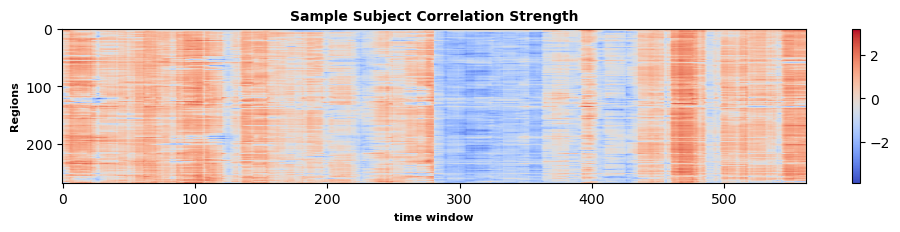

In [45]:
sample_strength=np.transpose(day1_strength_demeaned_std[70])
## plot the sample strength like a heatmap
plt.figure(figsize=(12,2))
plt.imshow(sample_strength,aspect='auto',cmap='coolwarm')
plt.colorbar()
plt.xlabel('time window',fontsize=8,fontweight='bold')
plt.ylabel('Regions',fontsize=8,fontweight='bold')
plt.title('Sample Subject Correlation Strength',fontsize=10,fontweight='bold')
plt.show()

In [82]:
## kmeans clustering for each subject
clustering_type=input("Enter the clustering type: hierarchical=1/K-Means=2")
print("You entered: "+str(clustering_type))

if str(clustering_type)=='2':

    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.cluster import KMeans
    n_sub_clusters=10
    day1_sub_clusters=np.zeros((len(day1_strength_demeaned),len(day1_strength_demeaned[0])))
    day2_sub_clusters=np.zeros((len(day2_strength_demeaned),len(day2_strength_demeaned[0])))
    for i in range(len(day1_strength_demeaned)):
        if i%10==0:
            print("Working on day 1 for subject "+str(i))
        clustering=KMeans(n_clusters=n_sub_clusters).fit(day1_strength_demeaned[i])
        day1_sub_clusters[i]=clustering.labels_
    for i in range(len(day2_strength_demeaned)):
        if i%10==0:
            print("Working on day 2 for subject "+str(i))
        clustering=KMeans(n_clusters=n_sub_clusters).fit(day2_strength_demeaned[i])
        day2_sub_clusters[i]=clustering.labels_

elif str(clustering_type)=='1':

    n_sub_clusters=10
    day1_sub_clusters=np.zeros((len(day1_strength_demeaned),len(day1_strength_demeaned[0])))
    day2_sub_clusters=np.zeros((len(day2_strength_demeaned),len(day2_strength_demeaned[0])))
    for i in range(len(day1_strength_demeaned)):
        if i%10==0:
            print("Working on day 1 for subject "+str(i))
        day1_sub_clusters[i]=correlation_based_hierarchical_clustering(day1_strength_demeaned[i],n_sub_clusters)

    for i in range(len(day2_strength_demeaned)):
        if i%10==0:
            print("Working on day 2 for subject "+str(i))
        day2_sub_clusters[i]=correlation_based_hierarchical_clustering(day2_strength_demeaned[i],n_sub_clusters)

    day1_sub_clusters=day1_sub_clusters-1
    day2_sub_clusters=day2_sub_clusters-1

else:
    print(f"Invalid input, clustering type should be 1 or 2, you entered {clustering_type}")

You entered: 1
Working on day 1 for subject 0
Working on day 1 for subject 10
Working on day 1 for subject 20
Working on day 1 for subject 30
Working on day 1 for subject 40
Working on day 1 for subject 50
Working on day 1 for subject 60
Working on day 1 for subject 70
Working on day 1 for subject 80
Working on day 1 for subject 90
Working on day 2 for subject 0
Working on day 2 for subject 10
Working on day 2 for subject 20
Working on day 2 for subject 30
Working on day 2 for subject 40
Working on day 2 for subject 50
Working on day 2 for subject 60
Working on day 2 for subject 70
Working on day 2 for subject 80
Working on day 2 for subject 90


In [83]:
## get input from the user 
analysis_type=input("Enter the analysis type: strength=1/vec=2")
print("You entered: "+str(analysis_type))
if str(analysis_type)=='1':
    
    clusters_pool=strength_based_analysis(day1_strength_demeaned,day2_strength_demeaned,day1_sub_clusters,day2_sub_clusters,n_sub_clusters)
    
elif str(analysis_type)=='2':
    
    clusters_pool=corr_vec_based_analysis(day1_corr_mat,day2_corr_mat,day1_sub_clusters,day2_sub_clusters,n_sub_clusters)

else:
    print(f"Invalid input, analysis type should be 1 or 2, you entered {analysis_type}")

You entered: 1


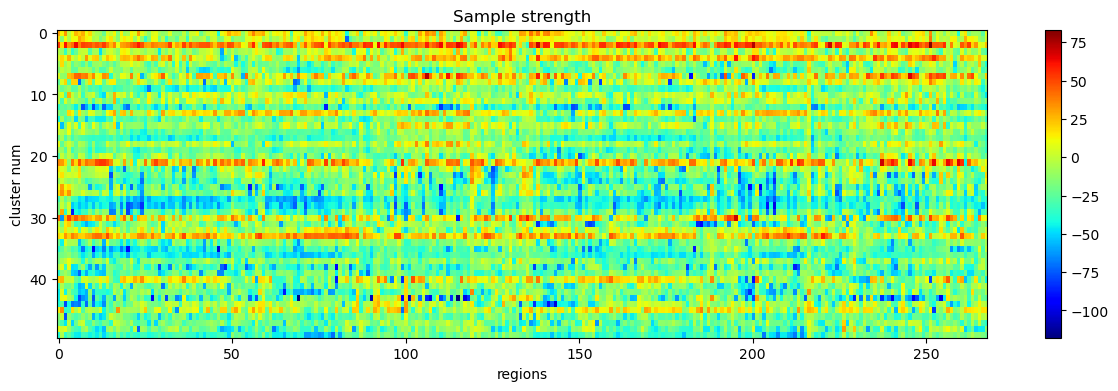

In [84]:
np.shape(clusters_pool)
## plot the first 50 clusters pool
plt.figure(figsize=(15,4))
plt.imshow(clusters_pool[250:300],aspect='auto',cmap='jet')
plt.colorbar()
plt.xlabel('regions')
plt.ylabel('cluster num')
plt.title('Sample strength')
plt.show()

In [117]:
## do kmeans clustering on the clusters_pool
from sklearn.cluster import KMeans
n_clusters=5
pool_labels=KMeans(n_clusters=n_clusters).fit(clusters_pool)
juv=pool_labels.labels_
## count the number of each label
unique, counts = np.unique(juv, return_counts=True)
uuu=dict(zip(unique, counts))
print(uuu)


{0: 262, 1: 647, 2: 415, 3: 593, 4: 83}


In [116]:
n_clusters=3
pool_labels=correlation_based_hierarchical_clustering(clusters_pool,n_clusters)
pool_labels=pool_labels-1
cluster_averages=np.zeros((n_clusters,len(clusters_pool[0])))
for i in range(n_clusters):
    cluster_averages[i]=np.mean(clusters_pool[pool_labels==i],axis=0)


unique, counts = np.unique(pool_labels, return_counts=True)
uuu=dict(zip(unique, counts))
print(uuu)


{0: 1989, 1: 7, 2: 4}


In [118]:
## AVERAGE REPRESENTATION OF EACH CLUSTER
cluster_averages=np.zeros((n_clusters,len(clusters_pool[0])))
for i in range(n_clusters):
    cluster_averages[i]=np.mean(clusters_pool[pool_labels.labels_==i],axis=0)

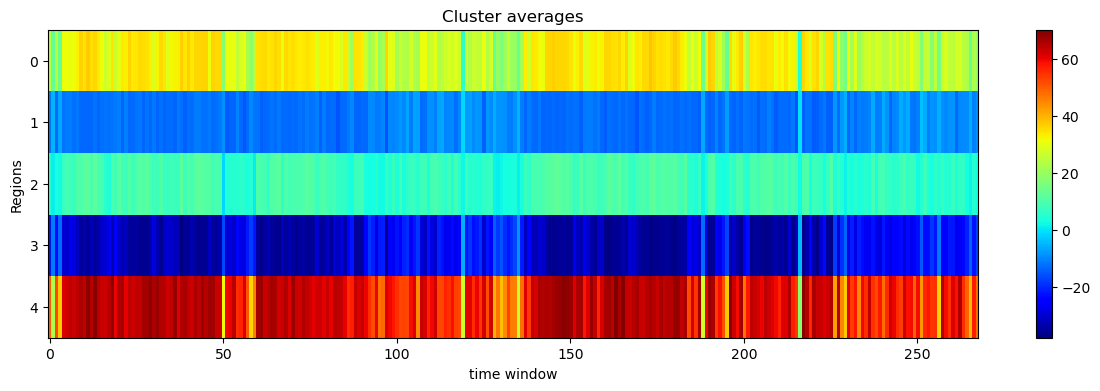

In [119]:
#3 plot the averages
plt.figure(figsize=(15,4))
plt.imshow(cluster_averages,aspect='auto',cmap='jet')
plt.colorbar()
plt.xlabel('time window')
plt.ylabel('Regions')
plt.title('Cluster averages')
plt.show()


In [59]:
np.shape(day1_strength_demeaned_std)

(100, 562, 268)

In [120]:
if str(analysis_type)=='1':
    ## RUN THIS IF WORKING WITH THE STRENGTHS
    day1_correlations_w_clusters=np.zeros((len(day1_strength_demeaned_std),n_clusters,len(day1_strength_demeaned_std[0])))
    day2_correlations_w_clusters=np.zeros((len(day2_strength_demeaned_std),n_clusters,len(day2_strength_demeaned_std[0])))
    for i in range(len(day1_strength_demeaned_std)):
        if i%10==0:
            print("Working in day 1 for subject "+str(i))
        for j in range(n_clusters):
            for k in range(len(day1_strength_demeaned_std[0])):
                day1_correlations_w_clusters[i,j,k]=np.corrcoef(day1_strength_demeaned_std[i,k,:],cluster_averages[j,:])[0,1]
    for i in range(len(day2_strength_demeaned_std)):
        if i%10==0:
            print("Working in day 2 for subject "+str(i))
        for j in range(n_clusters):
            for k in range(len(day2_strength_demeaned_std[0])):
                day2_correlations_w_clusters[i,j,k]=np.corrcoef(day2_strength_demeaned_std[i,k,:],cluster_averages[j,:])[0,1]

if str(analysis_type)=='2':
    day1_correlations_w_clusters=np.zeros((len(day1_corr_mat_demeaned),n_clusters,len(day1_corr_mat_demeaned[0])))
    day2_correlations_w_clusters=np.zeros((len(day2_corr_mat_demeaned),n_clusters,len(day2_corr_mat_demeaned[0])))
    for i in range(len(day1_corr_mat_demeaned)):
        if i%10==0:
            print("We are in day 1 and working on subject "+str(i))
        for j in range(n_clusters):
            for k in range(len(day1_corr_mat_demeaned[0])):
                day1_correlations_w_clusters[i,j,k]=np.corrcoef(day1_corr_mat_demeaned[i,k,:],cluster_averages[j,:])[0,1]
    for i in range(len(day2_corr_mat_demeaned)):
        if i%10==0:
            print("We are in day 2 and working on subject "+str(i))
        for j in range(n_clusters):
            for k in range(len(day2_corr_mat_demeaned[0])):
                day2_correlations_w_clusters[i,j,k]=np.corrcoef(day2_corr_mat_demeaned[i,k,:],cluster_averages[j,:])[0,1]


Working in day 1 for subject 0


Working in day 1 for subject 10
Working in day 1 for subject 20
Working in day 1 for subject 30
Working in day 1 for subject 40
Working in day 1 for subject 50
Working in day 1 for subject 60
Working in day 1 for subject 70
Working in day 1 for subject 80
Working in day 1 for subject 90
Working in day 2 for subject 0
Working in day 2 for subject 10
Working in day 2 for subject 20
Working in day 2 for subject 30
Working in day 2 for subject 40
Working in day 2 for subject 50
Working in day 2 for subject 60
Working in day 2 for subject 70
Working in day 2 for subject 80
Working in day 2 for subject 90


In [121]:
if str(analysis_type)=='1':
    maximum_correlation_clusters_day1=np.zeros((len(day1_strength_demeaned_std),len(day1_strength_demeaned_std[0])))
    maximum_correlation_clusters_day2=np.zeros((len(day2_strength_demeaned_std),len(day2_strength_demeaned_std[0])))
    for i in range(len(day1_strength_demeaned_std)):
        for j in range(len(day1_strength_demeaned_std[0])):
            maximum_correlation_clusters_day1[i,j]=np.argmax(day1_correlations_w_clusters[i,:,j])

    for i in range(len(day2_strength_demeaned_std)):
        for j in range(len(day2_strength_demeaned_std[0])):
            maximum_correlation_clusters_day2[i,j]=np.argmax(day2_correlations_w_clusters[i,:,j])

if str(analysis_type)=='2':
    maximum_correlation_clusters_day1=np.zeros((len(day1_corr_mat_demeaned),len(day1_corr_mat_demeaned[0])))
    maximum_correlation_clusters_day2=np.zeros((len(day2_corr_mat_demeaned),len(day2_corr_mat_demeaned[0])))
    for i in range(len(day1_corr_mat_demeaned)):
        for j in range(len(day1_corr_mat_demeaned[0])):
            maximum_correlation_clusters_day1[i,j]=np.argmax(day1_correlations_w_clusters[i,:,j])

    for i in range(len(day2_corr_mat_demeaned)):
        for j in range(len(day2_corr_mat_demeaned[0])):
            maximum_correlation_clusters_day2[i,j]=np.argmax(day2_correlations_w_clusters[i,:,j])

In [122]:
## check that each row of the two matrices have at least one zero
problematic=[]
for i in range(len(maximum_correlation_clusters_day1)):
    if 0 not in maximum_correlation_clusters_day1[i]:
        print("day 1 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 1 not in maximum_correlation_clusters_day1[i]:
        print("day 1 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 2 not in maximum_correlation_clusters_day1[i]:
        print("day 1 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 3 not in maximum_correlation_clusters_day1[i]:
        print("day 1 subject "+str(i)+" has a problem")
    if 4 not in maximum_correlation_clusters_day1[i]:
        print("day 1 subject "+str(i)+" has a problem")
    
for i in range(len(maximum_correlation_clusters_day2)):
    if 0 not in maximum_correlation_clusters_day2[i]:
        print("day 2 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 1 not in maximum_correlation_clusters_day2[i]:
        print("day 2 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 2 not in maximum_correlation_clusters_day2[i]:
        print("day 2 subject "+str(i)+" has a problem")
        problematic.append(i)
    if 3 not in maximum_correlation_clusters_day2[i]:
        print("day 2 subject "+str(i)+" has a problem")
    if 4 not in maximum_correlation_clusters_day2[i]:
        print("day 2 subject "+str(i)+" has a problem")
        
problematic=np.unique(problematic)
    

In [123]:
final_labels_day1=maximum_correlation_clusters_day1
final_labels_day2=maximum_correlation_clusters_day2
average_state_representation_day1=np.zeros((len(day1_corr_mat),n_clusters,num_regs,num_regs))
average_state_representation_day2=np.zeros((len(day1_corr_mat),n_clusters,num_regs,num_regs))
for i in range(len(day1_corr_mat)):
    for j in range(n_clusters):
        if i%10==0:
            print("Working on subject "+str(i)+" and cluster "+str(j)+" for day 1")
        average_state_representation_day1[i,j,:,:]=get_back_to_mat(np.mean(day1_corr_mat_demeaned[i,final_labels_day1[i]==j,:],axis=0),num_regs)
print("average_state_representation_day1 done")
for i in range(len(day1_corr_mat)):
    for j in range(n_clusters):
        if i%10==0:
            print("Working on subject "+str(i)+" and cluster "+str(j)+" for day 2")
        average_state_representation_day2[i,j,:,:]=get_back_to_mat(np.mean(day2_corr_mat_demeaned[i,final_labels_day2[i]==j,:],axis=0),num_regs)
print("average_state_representation_day2 done")

Working on subject 0 and cluster 0 for day 1
Working on subject 0 and cluster 1 for day 1
Working on subject 0 and cluster 2 for day 1
Working on subject 0 and cluster 3 for day 1
Working on subject 0 and cluster 4 for day 1
Working on subject 10 and cluster 0 for day 1
Working on subject 10 and cluster 1 for day 1
Working on subject 10 and cluster 2 for day 1
Working on subject 10 and cluster 3 for day 1
Working on subject 10 and cluster 4 for day 1
Working on subject 20 and cluster 0 for day 1
Working on subject 20 and cluster 1 for day 1
Working on subject 20 and cluster 2 for day 1
Working on subject 20 and cluster 3 for day 1
Working on subject 20 and cluster 4 for day 1
Working on subject 30 and cluster 0 for day 1
Working on subject 30 and cluster 1 for day 1
Working on subject 30 and cluster 2 for day 1
Working on subject 30 and cluster 3 for day 1
Working on subject 30 and cluster 4 for day 1
Working on subject 40 and cluster 0 for day 1
Working on subject 40 and cluster 1 for

In [124]:
num_subjects=100
day1_corr_mat_transposed = np.transpose(average_state_representation_day1, (1, 0, 2, 3))
day2_corr_mat_transposed = np.transpose(average_state_representation_day2, (1, 0, 2, 3))
day1_average_corr_vecs=np.zeros((n_clusters,num_subjects,num_regs*(num_regs-1)//2))
day2_average_corr_vecs=np.zeros((n_clusters,num_subjects,num_regs*(num_regs-1)//2))
for i in range(n_clusters):
    day1_average_corr_vecs[i]=upper_triangular_vector(day1_corr_mat_transposed[i])
    day2_average_corr_vecs[i]=upper_triangular_vector(day2_corr_mat_transposed[i])

In [125]:
## get correlation coefficient between each possible pair of subjects
num_subjects=100
states_correlations=np.zeros((n_clusters,num_subjects,num_subjects))
for i in range(n_clusters):
    print("Working on cluster "+str(i))
    for j in range(num_subjects):
        if j%10==0:
            print("Working on subject "+str(j))
        for k in range(num_subjects):
            ## if day1_corr_mat_averages[j,i,:,:] or day2_corr_mat_averages[k,i,:,:] are all zero, then the correlation is zero, continue
            if np.all(day1_corr_mat_demeaned[i,j,:]==0) or np.all(day2_corr_mat_demeaned[i,k,:]==0):
                continue
            ## for now I removed the arctanh
            states_correlations[i,j,k]=np.corrcoef(day1_average_corr_vecs[i,j,:],day2_average_corr_vecs[i,k,:])[0,1]

Working on cluster 0
Working on subject 0


Working on subject 10
Working on subject 20
Working on subject 30
Working on subject 40
Working on subject 50
Working on subject 60
Working on subject 70
Working on subject 80
Working on subject 90
Working on cluster 1
Working on subject 0
Working on subject 10
Working on subject 20
Working on subject 30
Working on subject 40
Working on subject 50
Working on subject 60
Working on subject 70
Working on subject 80
Working on subject 90
Working on cluster 2
Working on subject 0
Working on subject 10
Working on subject 20
Working on subject 30
Working on subject 40
Working on subject 50
Working on subject 60
Working on subject 70
Working on subject 80
Working on subject 90
Working on cluster 3
Working on subject 0
Working on subject 10
Working on subject 20
Working on subject 30
Working on subject 40
Working on subject 50
Working on subject 60
Working on subject 70
Working on subject 80
Working on subject 90
Working on cluster 4
Working on subject 0
Working on subject 10
Working on subject

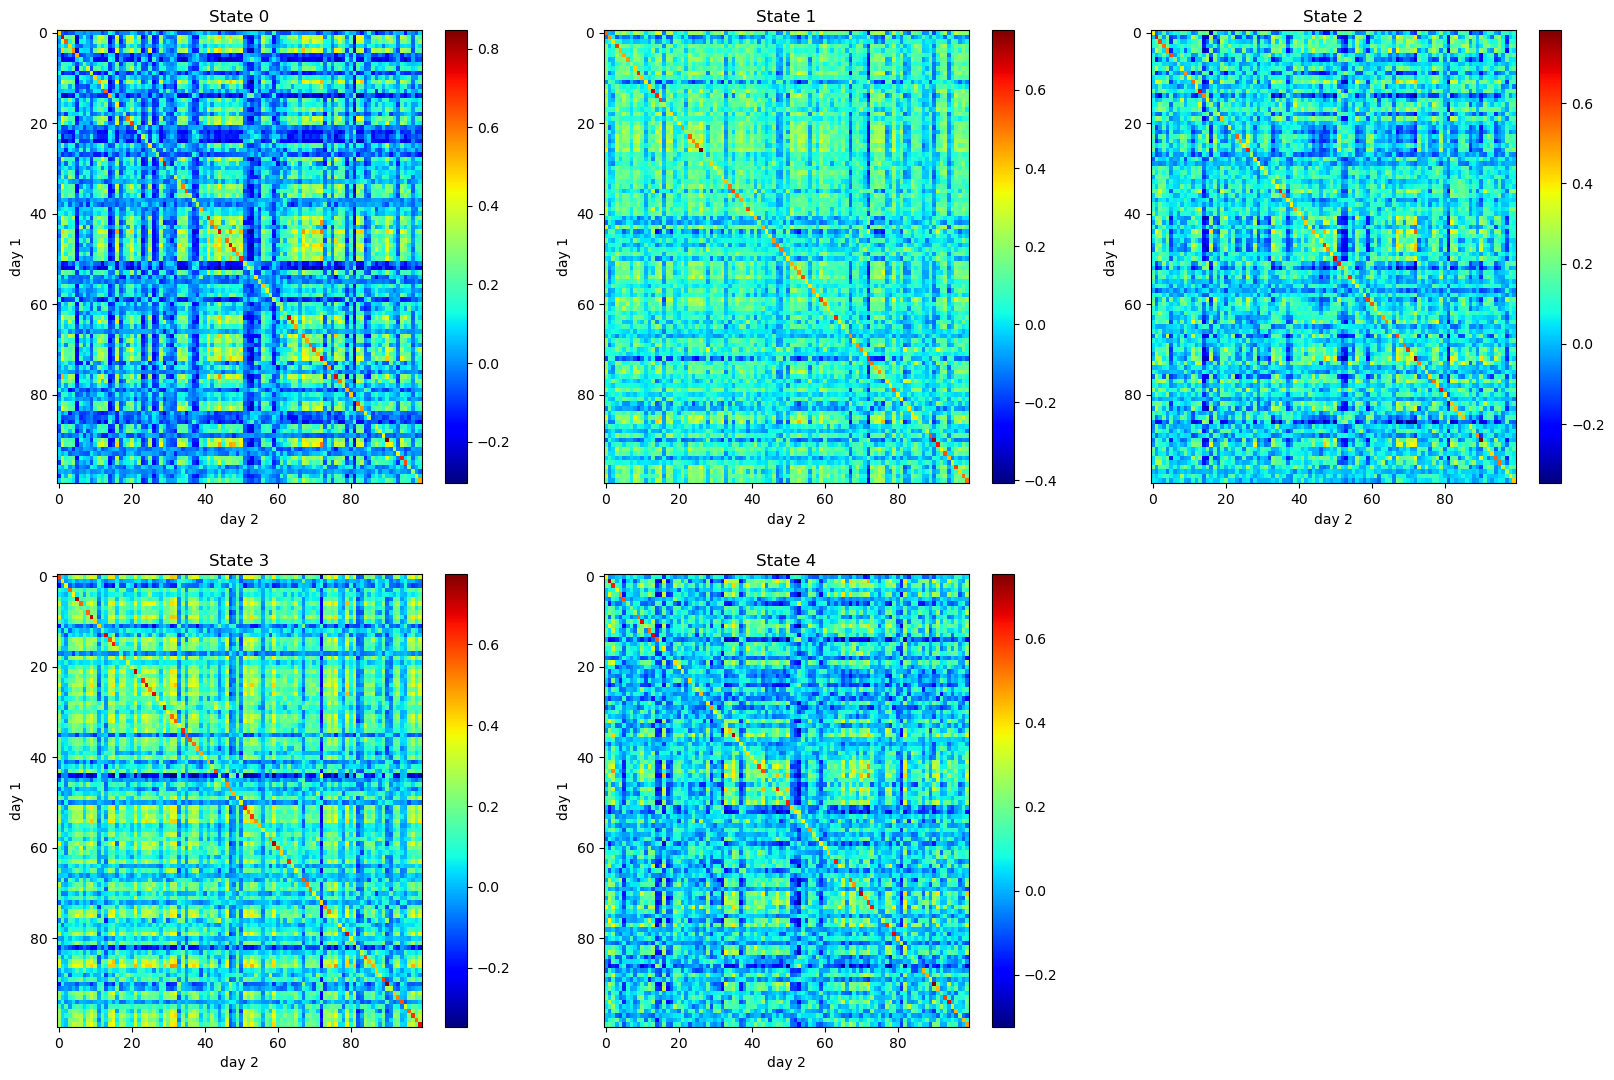

In [126]:
## plot the 9 states correlation matrix in a subplot of 9 figures
plt.figure(figsize=(20,20))
for i in range(n_clusters):
    plt.subplot(3,3,i+1)
    plt.imshow(states_correlations[i],aspect='auto',cmap='jet')
    plt.colorbar()
    plt.xlabel('day 2')
    plt.ylabel('day 1')
    plt.title('State '+str(i))

In [127]:
problematic_array = np.array(problematic)
print(len(problematic_array))
# Use np.delete to remove specified indices along axis 1
if len(problematic_array)>0:
    day1_average_corr_vecs_comp = np.delete(day1_average_corr_vecs, problematic_array, axis=1)
    day2_average_corr_vecs_comp = np.delete(day2_average_corr_vecs, problematic_array, axis=1)

    day1_average_corr_vecs_comp=np.delete(day1_average_corr_vecs,problematic,axis=1)
    day2_average_corr_vecs_comp=np.delete(day2_average_corr_vecs,problematic,axis=1)
    comp_std_day1=np.zeros_like(day1_average_corr_vecs_comp)
    comp_std_day2=np.zeros_like(day2_average_corr_vecs_comp)
    for i in range(n_clusters):
        for j in range(num_subjects-len(problematic)):
            current_mean=np.mean(day1_average_corr_vecs_comp[i,j])
            current_std=np.std(day1_average_corr_vecs_comp[i,j])
            comp_std_day1[i,j]=(day1_average_corr_vecs_comp[i,j]-current_mean)/current_std
            current_mean=np.mean(day2_average_corr_vecs_comp[i,j])
            current_std=np.std(day2_average_corr_vecs_comp[i,j])
            comp_std_day2[i,j]=(day2_average_corr_vecs_comp[i,j]-current_mean)/current_std

    final_vecs_day1=np.zeros((num_subjects-len(problematic),n_clusters*num_regs*(num_regs-1)//2))
    final_vecs_day2=np.zeros((num_subjects-len(problematic),n_clusters*num_regs*(num_regs-1)//2))
    for i in range(len(final_vecs_day1)):
        final_vecs_day1[i]=np.concatenate(comp_std_day1[:,i,:])
        final_vecs_day2[i]=np.concatenate(comp_std_day2[:,i,:])

    ## get the correlation between each pair of subjects
    final_correlations=np.zeros((num_subjects-len(problematic),num_subjects-len(problematic)))
    for i in range(len(final_vecs_day1)):
        for j in range(len(final_vecs_day2)):
            final_correlations[i,j]=np.corrcoef(final_vecs_day1[i],final_vecs_day2[j])[0,1]

else:
    final_vecs_day1=np.zeros((num_subjects,n_clusters*num_regs*(num_regs-1)//2))
    final_vecs_day2=np.zeros((num_subjects,n_clusters*num_regs*(num_regs-1)//2))
    for i in range(len(final_vecs_day1)):
        final_vecs_day1[i]=np.concatenate(day1_average_corr_vecs[:,i,:])
        final_vecs_day2[i]=np.concatenate(day2_average_corr_vecs[:,i,:])

    ## get the correlation between each pair of subjects
    final_correlations=np.zeros((num_subjects,num_subjects))
    for i in range(len(final_vecs_day1)):
        for j in range(len(final_vecs_day2)):
            final_correlations[i,j]=np.corrcoef(final_vecs_day1[i],final_vecs_day2[j])[0,1]

0


In [71]:
np.shape(final_vecs_day1)

(100, 107334)

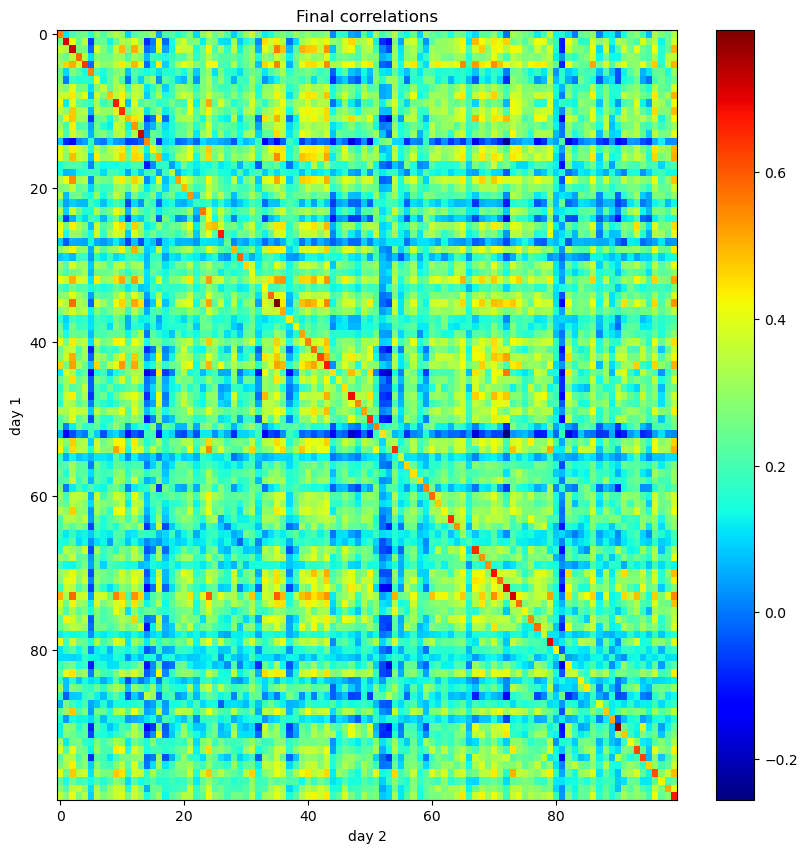

In [128]:
plt.figure(figsize=(10,10))
plt.imshow(final_correlations,aspect='auto',cmap='jet')
plt.colorbar()
plt.xlabel('day 2')
plt.ylabel('day 1')
plt.title('Final correlations')
plt.show()


In [129]:
count=0
for i in range(num_subjects-len(problematic)):
    if np.argmax(final_correlations[:,i])==i:
        count+=1
print("The number of subjects that are matched to themselves is: "+str(count))


## count the number of rows in final_correlations matrix that the diagonal is the max
count=0
for i in range(len(final_correlations)):
    if np.argmax(final_correlations[i])==i:
        count+=1
print("The number of subjects that are matched to themselves is: "+str(count))

The number of subjects that are matched to themselves is: 83
The number of subjects that are matched to themselves is: 82
